In [1]:
import sys 
sys.path.append('scripts')
from TuneClass import *
import TuneClass
#import Executable
import Envelope
#from Executable import Tune
#from Executable import main
import imp
#imp.reload(dbreader)
#imp.reload(Executable)
imp.reload(TuneClass)
imp.reload(Envelope)
import matplotlib.pyplot as plt
import re
plt.rcParams['font.family'] = 'Times New Roman'


C:\Users\E7450\AppData\Local\Temp\ipykernel_10644\2021919818.py:9: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import fcwt
from pydub import AudioSegment
import scipy.io.wavfile as wav  

In [ ]:
class Tune:
    def __init__(self, X=None, T=None, R=None, M=None, L=None, key=None, abc=""):
        self.X = X  # Reference number
        self.T = T  # Title
        self.R = R  # Rhythm type
        self.M = M  # Meter
        self.L = L  # Default note length
        self.K = key  # Key signature
        self.abc = abc  # Full ABC notation
        self.notes = []  # Placeholder for extracted notes

    def extract_notes(self):
        """ Extracts the note sequence from ABC notation. """
        self.notes = abc_to_notestring(self.abc)
        self.notes = keychanger(self,self.key)
        self.tones = notes_to_semitones2(self,universal_encoder)  # Update after ABC is fully set
        self.waveform = np.float32(constructor(self,'piano',.15))
    def __str__(self):
        return f"X: {self.X}, T: {self.T}, R: {self.R}, M: {self.M}, L: {self.L}, K: {self.K}, Notes: {self.notes[:50]}..."

    def play(self,duration = .125,instrument='piano'):
        waveform = constructor(self,instrument,duration)
        waveform = np.float32(waveform)
        sd.play(waveform,samplerate=8000)
        sd.wait()

# Read the file and parse entries
tunes = []
with open("reels.txt", "r", encoding="utf-8") as file:
    current_tune = None  # Holds the current tune being parsed

    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        
        if not line:  # Empty line indicates a new tune might be starting
            if current_tune:  # If there's an active tune, store it
                tunes.append(current_tune)
            current_tune = None  # Reset for the next tune
            continue

        if line.startswith("X:"):  # Start of a new tune
            if current_tune:  # Store the previous tune before starting a new one
                tunes.append(current_tune)
            current_tune = Tune(X=line[2:].strip())  # Create new tune instance
        elif line.startswith("T:") and current_tune:
            current_tune.T = line[2:].strip()
        elif line.startswith("R:") and current_tune:
            current_tune.R = line[2:].strip()
        elif line.startswith("M:") and current_tune:
            current_tune.M = line[2:].strip()
        elif line.startswith("L:") and current_tune:
            current_tune.L = line[2:].strip()
        elif line.startswith("K:") and current_tune:
            current_tune.key = line[2:].strip()
        elif current_tune and not re.match(r"^[SCZ]:", line):  # All other lines are part of the ABC notation
            current_tune.abc += line + "\n"

    # Append the last parsed tune (if any)
    if current_tune:
        current_tune.extract_notes()
        tunes.append(current_tune)
for i in tunes:
    i.extract_notes()


In [4]:
# image editing
import cv2
import numpy as np

def reduce_resolution(image, new_shape):
    # Compute magnitude and phase
    magnitude = np.abs(image)
    phase = np.angle(image)
    
    # Resize using OpenCV
    magnitude_resized = cv2.resize(magnitude, new_shape, interpolation=cv2.INTER_AREA)  # Best for downscaling
    phase_resized = cv2.resize(phase, new_shape, interpolation=cv2.INTER_LINEAR)  # Phase needs smooth interpolation
    
    # Reconstruct the complex image
    resized_image = magnitude_resized * np.exp(1j * phase_resized)
    
    return resized_image

def increase_contrast_complex(image, alpha=2.0, beta=0):

    # Separate magnitude and phase
    magnitude = np.abs(image)
    phase = np.angle(image)
    
    # Apply contrast enhancement to magnitude
    magnitude_contrasted = np.clip(alpha * magnitude + beta, 0, 1)
    
    # Reconstruct the complex image with the enhanced magnitude
    contrasted_image = magnitude_contrasted * np.exp(1j * phase)
    
    return contrasted_image

In [26]:
# transform, wavelet coherence, transform plot
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve1d,zoom
import scipy.io.wavfile as wav
from PIL import Image, ImageEnhance
# Compute the wavelet coherence
def gamma_correction_complex(image, gamma=.35,clip_point = .5):
    # Compute magnitude and phase    
    magnitude = np.abs(image)
    phase = np.angle(image)
    magnitude_max = np.max(magnitude)
    if magnitude_max > 0:
        magnitude = magnitude / magnitude_max  # Normalize to [0,1]
    magnitude = np.clip(magnitude*4,clip_point,1)
    # Apply gamma correction to the magnitude
    magnitude_corrected = np.power(magnitude, gamma)
    blur_strength = 2
    blur_kernel = np.ones(blur_strength) / blur_strength  # 1D blur kernel
    magnitude_corrected = convolve1d(magnitude_corrected, blur_kernel, axis=1, mode='reflect')

    # Reconstruct the complex image
    corrected_image = magnitude_corrected * np.exp(1j * phase)
    return corrected_image

def transform(signal1,frame_rate,clip_point,correction= True):
    highest = 4000
    lowest = 200
    nfreqs = 200
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')
    coeffs1 = reduce_resolution(coeffs1, (800, 300))
    if correction:
        coeffs1 = gamma_correction_complex(coeffs1,clip_point = clip_point)
    return coeffs1,freqs

def transform_plot(signal,frame_rate,clip_point,correction = True):


    coeffs1,freqs = transform(signal,frame_rate,clip_point,correction)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, len(signal)/frame_rate, len(freqs),0]
    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(coeffs1), aspect='auto', extent=extent, cmap='jet')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Magnitude')
    cbar.set_ticks([])  
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    #plt.title('Wavelet Transform Magnitude')
    plt.tight_layout()
    plt.show()
    return coeffs1,freqs

def cross_wavelet(coeffs1,coeffs2,frame_rate,freqs):

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    return S12
def wavelet_coherence(coeffs1,coeffs2,frame_rate,freqs):

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        return data
        #ensure only horizontal smoothing
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    #coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))

    return coherence, freqs 




In [6]:
def match_signal_length(signal1, signal2, pad_value=0):

    len1 = len(signal1)
    len2 = len(signal2)
    
    if len2 > len1:
        # Trim signal2 if it's longer
        return signal2[:len1]
    elif len2 < len1:
        # Pad signal2 if it's shorter
        padding = np.full((len1 - len2,), pad_value)  # Create padding array
        return np.concatenate((signal2, padding))
    else:
        # Already the same length
        return signal2


In [7]:
def coherence_signals(tune,recording,frame_rate,plot=True):
    
    audio_data1 = np.array(recording, dtype=np.float32)
    audio_data1 -= np.mean(audio_data1)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max1 = np.max(np.abs(audio_data1))
    if max1 > 0:
        data1 = audio_data1 / max1
    data2 = tune.waveform
    audio_data2 = np.array(data2, dtype=np.float32)
    audio_data2 -= np.mean(audio_data2)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max2 = np.max(np.abs(audio_data2))
    if max2 > 0:
        data2 = audio_data2 / max2
        
    data2 = match_signal_length(data1, data2)
    coeffs1,freqs = transform(data1,frame_rate,.05)
    coeffs2,_ = transform(data2,frame_rate,.05)
    coherence, freqs = wavelet_coherence(coeffs1,coeffs2, frame_rate,freqs)
    extent=[0, len(data1)/frame_rate, len(freqs),0]

    coherence = np.clip(coherence,.7,None)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    if plot:
        plt.figure(figsize=(10, 6))
        plt.imshow(coherence, aspect='auto', extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])
        plt.xticks(np.linspace(0, len(data1)/frame_rate, 5))
        plt.colorbar(label='Coherence')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(f'Wavelet Coherence: {tune.T}')
        plt.show()
    return coeffs1,coeffs2,freqs,coherence


In [27]:
frame_rate = 8000
def create_transforms(tunes):
    for i in tunes:
        audio_data1 = np.array(i.waveform, dtype=np.float32)
        audio_data1 -= np.mean(audio_data1)
        # 2. Divide by the maximum absolute value to scale between -1 and 1
        max1 = np.max(np.abs(audio_data1))
        if max1 > 0:
            data1 = audio_data1 / max1
        i.transform = transform(data1,frame_rate,clip_point = .3)

In [9]:
# coherence plot
from IPython.display import display
def coherence_plot(tune,recording_transform,frame_rate,plot=True): 
    # should be able to take in a tune object and a recording object and
    # efficiently compute the coherence between the two waveforms. without having 
    # to recompute the wavelet transform for the tune object
    coeffs1 = tune.transform[0]
    coeffs2 = recording_transform
    freqs = tune.transform[1]
    coherence, freqs = wavelet_coherence(coeffs1,coeffs2, frame_rate,freqs)
    extent=[0, len(tune.waveform)/frame_rate, len(freqs),0]

    coherence = np.where(coherence<.1,0,coherence)
    max1 = np.max(np.abs(coherence))
    min1 = np.min(np.abs(coherence))
    coherence = (coherence-min1) / (max1-min1)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    plt_obj = None
    if plot:
        plt.figure(figsize=(10, 6))
        plt.imshow(coherence, aspect='auto', extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])
        plt.xticks(np.linspace(0, len(tune.waveform)/frame_rate, 5))
        plt.colorbar(label='Coherence')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(f'Wavelet Coherence: {tune.T}')
        plt_obj = plt.gcf()
        plt.close()

        
    return coeffs1,coeffs2,freqs,coherence,plt_obj


In [10]:
def align_using_cross_correlation(ref_signal, target_signal, sr):

    # Compute cross-correlation
    corr = np.correlate(target_signal, ref_signal, mode="full")
    lag = np.argmax(corr) - len(ref_signal) + 1  # Find the best shift

    # Apply time shift (trim or pad)
    if lag > 0:
        aligned_target = target_signal[lag:]  # Cut off leading part
    else:
        aligned_target = np.pad(target_signal, (abs(lag), 0), mode="constant")  # Pad with zeros

    return aligned_target

In [11]:
# m4a to reel, trim silence
AudioSegment.converter = "C:/Users/24261951/Documents/Projects/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"                  
from pydub import utils, AudioSegment

def get_prober_name():
    return "C:/Users/24261951/Documents/Projects/ffmpeg-master-latest-win64-gpl/bin/ffprobe.exe"
utils.get_prober_name = get_prober_name

def trim_silence(signal, threshold):
    """
    Removes all values before the signal first exceeds the threshold.
    
    Parameters:
    signal (numpy array): The input signal
    threshold (float): The minimum amplitude to start keeping values
    
    Returns:
    numpy array: Trimmed signal starting from the first peak above the threshold
    """
    # Find the first index where the signal exceeds the threshold
    index = np.argmax(np.abs(signal) >= threshold)
    
    # Slice the signal from that index onwards
    return signal[index:] if np.abs(signal[index]) >= threshold else np.array([])


In [12]:
# m4a to reel, wav to reel
def m4a_to_reel(file):
    audio = AudioSegment.from_file(file,format='m4a')
    audio = audio.set_frame_rate(8000)
    if audio.channels == 2:
        samples = samples.reshape((-1, 2)).mean(axis=1)
    audio = np.frombuffer(audio.raw_data,np.int16)
    audio = (audio)/max(abs(audio))
    audio = trim_silence(audio,0.5) # begin when playing starts
    audio = match_signal_length(tunes[0].waveform,audio)
    #audio = align_using_cross_correlation(tunes[1].waveform,audio,8000)
    return audio

def wav_to_reel(file):
    audio = AudioSegment.from_file(file,format='wav')
    audio = audio.set_frame_rate(8000)
    if audio.channels == 2:
        audio = audio.set_channels(1)
    audio = np.frombuffer(audio.raw_data,np.int16)
    audio = (audio)/max(abs(audio))
    audio = trim_silence(audio,0.5) # begin when playing starts
    audio = match_signal_length(tunes[0].waveform,audio)
    #audio = align_using_cross_correlation(tunes[1].waveform,audio,8000)
    return audio

def wav_to_data(file,set_fr = False):
    audio = AudioSegment.from_file(file,format='wav')
    if set_fr:
        audio = audio.set_frame_rate(8000)
    if audio.channels == 2:
        audio = audio.set_channels(1)
    audio = np.frombuffer(audio.raw_data,np.int16)
    audio = (audio)/max(abs(audio))
    audio = trim_silence(audio,0.5) # begin when playing starts
    #audio = align_using_cross_correlation(tunes[1].waveform,audio,8000)
    return audio

In [13]:
from PIL import Image
import os
import matplotlib.pyplot as plt

def create_subplots_from_png(directory):
    # Get list of all .png files in the directory (sorted for consistency)
    png_files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])

    num_files = len(png_files)
    if num_files == 0:
        print("No PNG files found.")
        return

    cols = 1
    rows = num_files

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))

    # Ensure axes is always iterable
    if num_files == 1:
        axes = [axes]

    for ax, png_file in zip(axes, png_files):
        img_path = os.path.join(directory, png_file)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_sums(sums):
    # Extract keys and values from the sums dictionary
    keys = list(sums.keys())
    values = np.array(list(sums.values()))  # Convert values to a NumPy array
    values = values - min(values)  # Normalize to start from 0
    
    # Create a DataFrame for easier plotting with Seaborn
    data = pd.DataFrame({'Tune': keys, 'Total Coherence': values})
    
    # Create a horizontal bar plot with Seaborn
    plt.figure(figsize=(12, 15))
    sns.barplot(x='Total Coherence', y='Tune', data=data,color = 'navy', orient='h')
    plt.xlabel('Total Coherence')
    plt.ylabel('')
    plt.xticks([],fontsize=10)

    #plt.title('Gross Coherence for Each Tune')
    plt.tight_layout()
    plt.show()

In [15]:
# workflow
import os
import shutil
def workflow(recording,frame_rate = 8000,plot = False,save = False,title = 'unspecified title',clip_point = .1):
    topk = 3 # number of top guesses to return
    file = f'recordings/{recording}'
    if file[-3:] == ('m4a'):
        tune = m4a_to_reel(file)
    elif file[-3:] == ('wav'):
        tune = wav_to_reel(file)
    elif type(recording) == np.ndarray or type(file) == list:
        tune = recording
        recording = title
    else:
        return "Unsupported input format"
    sums = {}
    tform = transform(tune,frame_rate,clip_point = clip_point,correction = True)
    
    output_dir = f'coherence_results/{recording}'
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # Remove only if it exists
    os.makedirs(output_dir)
    # Calculate the required number of rows
    plts = {}
    for n,i in enumerate(tunes):
        _,_,_,coh,plt_obj = coherence_plot(i,tform[0],frame_rate,plot=True)
        plts[i.T] = plt_obj
   
        sums[i.T] = np.where(coh<.5,0,coh).sum()

    top_keys = sorted(sums, key=sums.get, reverse=True)[:topk]

    
    if plot:
        for i in plts:
            if i in top_keys:
                value = plts[i]
                value.savefig(f'coherence_results/{recording}/{i}.png')

    if plot:
        if os.path.exists(f'coherence_results/{recording}'):
            create_subplots_from_png(f'coherence_results/{recording}/')
    if not save:
        shutil.rmtree(f'coherence_results/{recording}')
    min_value = min(sums.values())
    top_keys = sorted(sums, key=sums.get, reverse=True)[:5]
    print(f'Top Guesses: {top_keys}')
    # Divide all values by the minimum
    normalized_sums = {key: value - min_value + 5 for key, value in sums.items()}   
    keys = list(normalized_sums.keys())
    values = list(normalized_sums.values())
    if plot:
        plot_sums(normalized_sums)

    return sums


In [16]:
workflow(np.zeros(len(audio_data)),frame_rate,plot = True,save=False,title='test_recording',clip_point = .05)

NameError: name 'audio_data' is not defined

In [17]:
#metronome thread
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
import time
import threading


def generate_click(samplerate=44100):
    """Generates a short, percussive click sound."""
    duration = 0.1  # 10ms for sharp click
    samples = int(samplerate * duration)

    # White noise burst
    noise = np.random.uniform(-1.0, 1.0, samples) * 0.5  

    # Apply an envelope for fast decay
    envelope = np.linspace(1, 0, samples)  # Fast fade-out
    click_sound = noise * envelope

    return click_sound.astype(np.float32), duration  # Return both sound & duration


def generate_tone(frequency=1000, duration=0.1, samplerate=44100):
    """Generates a beep sound for count-in."""
    t = np.linspace(0, duration, int(samplerate * duration), endpoint=False)
    tone = 0.5 * np.sin(2 * np.pi * frequency * t)
    return tone.astype(np.float32), duration  # Return both sound & duration

def metronome_thread(bpm, num_clicks,count_in):
    """Plays a count-in (8 beeps) followed by exactly `num_clicks` metronome clicks."""
    global recording_active
    beat_interval = 60.0 / bpm  # Exact time per beat (seconds)

    beep_sound, beep_duration = generate_tone(frequency=1000, duration=0.1)  # Count-in sound
    click_sound, click_duration = generate_click()  # Sharp click

    with sd.OutputStream(samplerate=44100, channels=1) as stream:
        start_time = time.monotonic()  # Start timing reference

        # Count-in (8 beeps)
        for _ in range(count_in):
            if not recording_active:
                return
            stream.write(beep_sound)
            next_beat_time = start_time + (_ + 1) * beat_interval
            time.sleep(max(0, next_beat_time - time.monotonic()))  # Sync precisely

        # Play exactly `num_clicks` metronome clicks
        for i in range(num_clicks):
            if not recording_active:
                return
            stream.write(click_sound)
            next_beat_time = start_time + (i + 9) * beat_interval  # Continue timing after count-in
            time.sleep(max(0, next_beat_time - time.monotonic()))  # Sync precisely

def record_audio_with_metronome(bpm, num_clicks, samplerate,count_in):
    """Records audio while playing exactly `num_clicks` metronome clicks after a count-in."""
    global recording_active
    recording_active = True

    # Calculate recording duration (8 count-in beeps + num_clicks clicks)
    duration = ((num_clicks + count_in) * 60) / bpm  

    print(f"Recording for {duration:.2f} seconds with metronome at {bpm} BPM...")

    # Start the metronome in a separate thread
    metronome_threading = threading.Thread(target=metronome_thread, args=(bpm, num_clicks,count_in))
    metronome_threading.start()
    
    time.sleep(0.1)  # Ensures metronome starts before recording

    # Start recording
    audio_data = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=2, dtype=np.int16)
    sd.wait()  # Ensure the recording completes
    audio_data = np.mean(audio_data, axis=1, dtype=np.int16)

    recording_active = False  # Stop metronome after recording
    metronome_threading.join()

    # Save the recording
    return audio_data
    print(f"Recording saved as {filename}")

# Example usage
#bpm = 200
#num_clicks = 65 # Play exactly 64 clicks
#count_in = 9
#record_audio_with_metronome("metronome_record2.wav", bpm=bpm, num_clicks=num_clicks,count_in=count_in,samplerate=44100)


In [ ]:
import pickle

# Save the `tunes` object to a file
with open('tunes.pkl', 'wb') as file:
    pickle.dump(tunes, file)

print("Tunes object saved successfully")

Tunes object saved successfully


In [18]:
# load tunes
import pickle

# Load the `tunes` object from the file
with open('tunes.pkl', 'rb') as file:
    tunes = pickle.load(file)

print("tunes object loaded successfully")

tunes object loaded successfully


In [19]:
def fatten_waveform(waveform, threshold=0.2, ratio=4.0):
    waveform = waveform.astype(np.float32)


    abs_wave = np.abs(waveform)
    mask = abs_wave > threshold

    # Compress only values above the threshold
    compressed = waveform.copy()
    compressed[mask] = np.sign(waveform[mask]) * (
        threshold + (abs_wave[mask] - threshold) / ratio
    )

    # Normalize to max amplitude
    compressed /= np.max(np.abs(compressed))

    return compressed

In [58]:
def record(frame_rate = 8000,bpm = 200,num_clicks = 65,count_in = 9,save = False,plot = False,audio_data = None):
    #audio_data1 = record_audio_with_metronome(bpm = bpm,
    #                                         num_clicks = num_clicks,
    #                                         samplerate=frame_rate,
    #                                         count_in = count_in)
    audio_data1 = audio_data
    # capture the corresponding segment of the tune
    factor = frame_rate/8000
    window_size = 154800 *factor  # Fixed window size
    end_sample = int(factor*(-1 - 81)) # End of the window moves left each iteration - optimal
    start_sample = int(factor*(end_sample - window_size + 1))  # Ensure the window remains 154800 samples

    # Slice the audio data
    audio_data = audio_data1[start_sample:end_sample + 1]  # +1 to include `end_sample`
    filepath = 'unspecified title'
    #audio_data = fatten_waveform(audio_data,threshold=.2,ratio=4.0)
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(audio_data)
        plt.xticks(np.linspace(0,153600,10),labels=np.round(np.linspace(0, 19.2, 10),1))  # Set x-axis ticks to 10 equally spaced points between 0 and 19.2
        plt.yticks([])  # Turn off y-axis ticks

        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        #plt.title('Recorded Audio')
        plt.show()
        plt.tight_layout()

        transform_plot(audio_data,frame_rate,clip_point = .05)

    if save:
        inp = input('Save recording? (y/n): ')
        if inp.lower() == 'y':    
            filepath = input('YourName Intstrument TuneTitle')
            wav.write('recordings/'+filepath+'.wav',frame_rate,audio_data1)
            
            # Specify the name of the directory to be created
            directory = 'coherence_results/'+filepath

            # Check if the directory already exists
            if os.path.exists(directory):
                response = input(f"Results for '{directory}' already exists. Do you want to overwrite it? (y/n): ")
                if response.lower() == 'y':
                    shutil.rmtree(directory)  # Remove the existing directory
                    os.makedirs(directory)  # Create a new directory
                    print(f"Directory '{directory}' overwritten successfully")
                else:
                    print("Operation cancelled")
            else:
                os.makedirs(directory)
                print(f"Directory '{directory}' created successfully")
            wav.write('coherence_results/'+filepath+'/raw_audio.wav',frame_rate,audio_data1)
        else:
            return "no more like robin hood", "shall he roam through cricklewood"
    sums = workflow(audio_data,frame_rate,plot = plot,save=save,title=filepath)
  
    return sums,audio_data

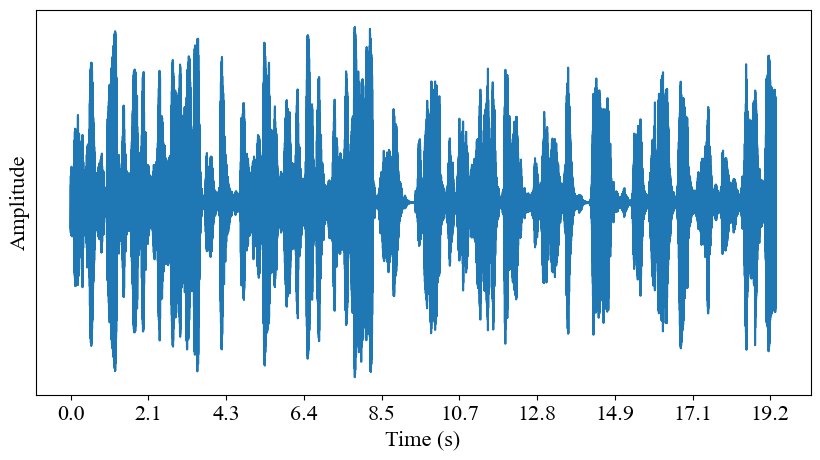

<Figure size 640x480 with 0 Axes>

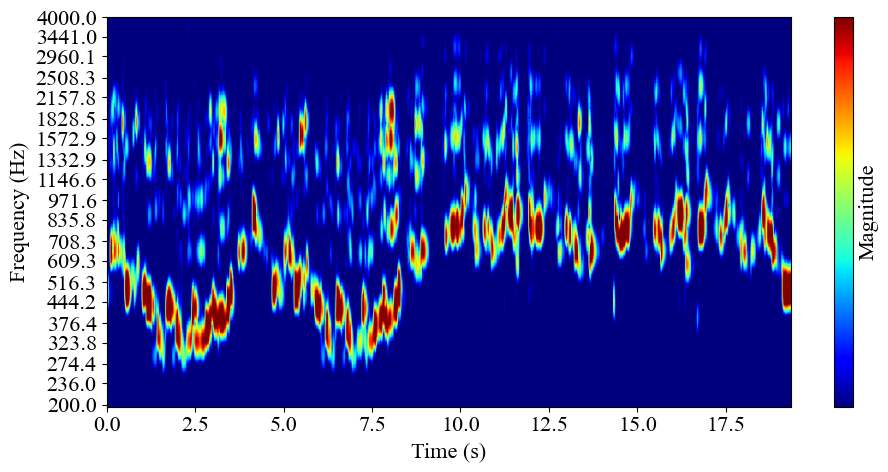

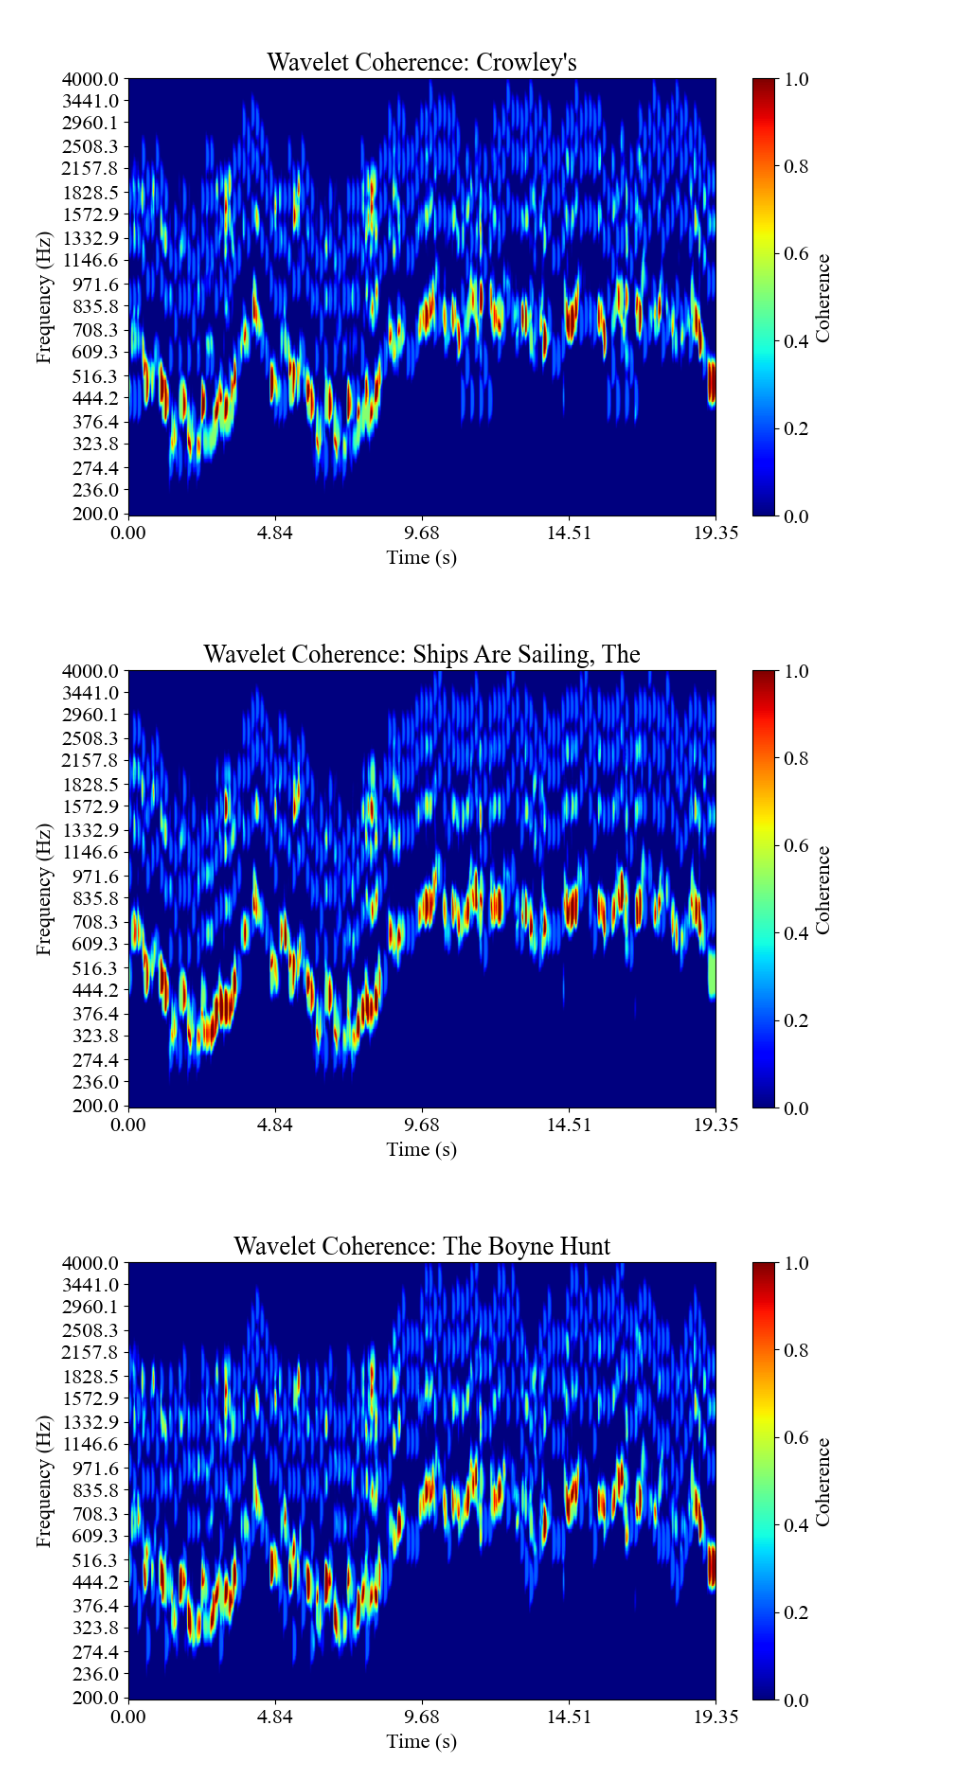

Top Guesses: ['Ships Are Sailing, The', 'The Boyne Hunt', "Crowley's", 'Castle Kelly', 'The Holy Land']


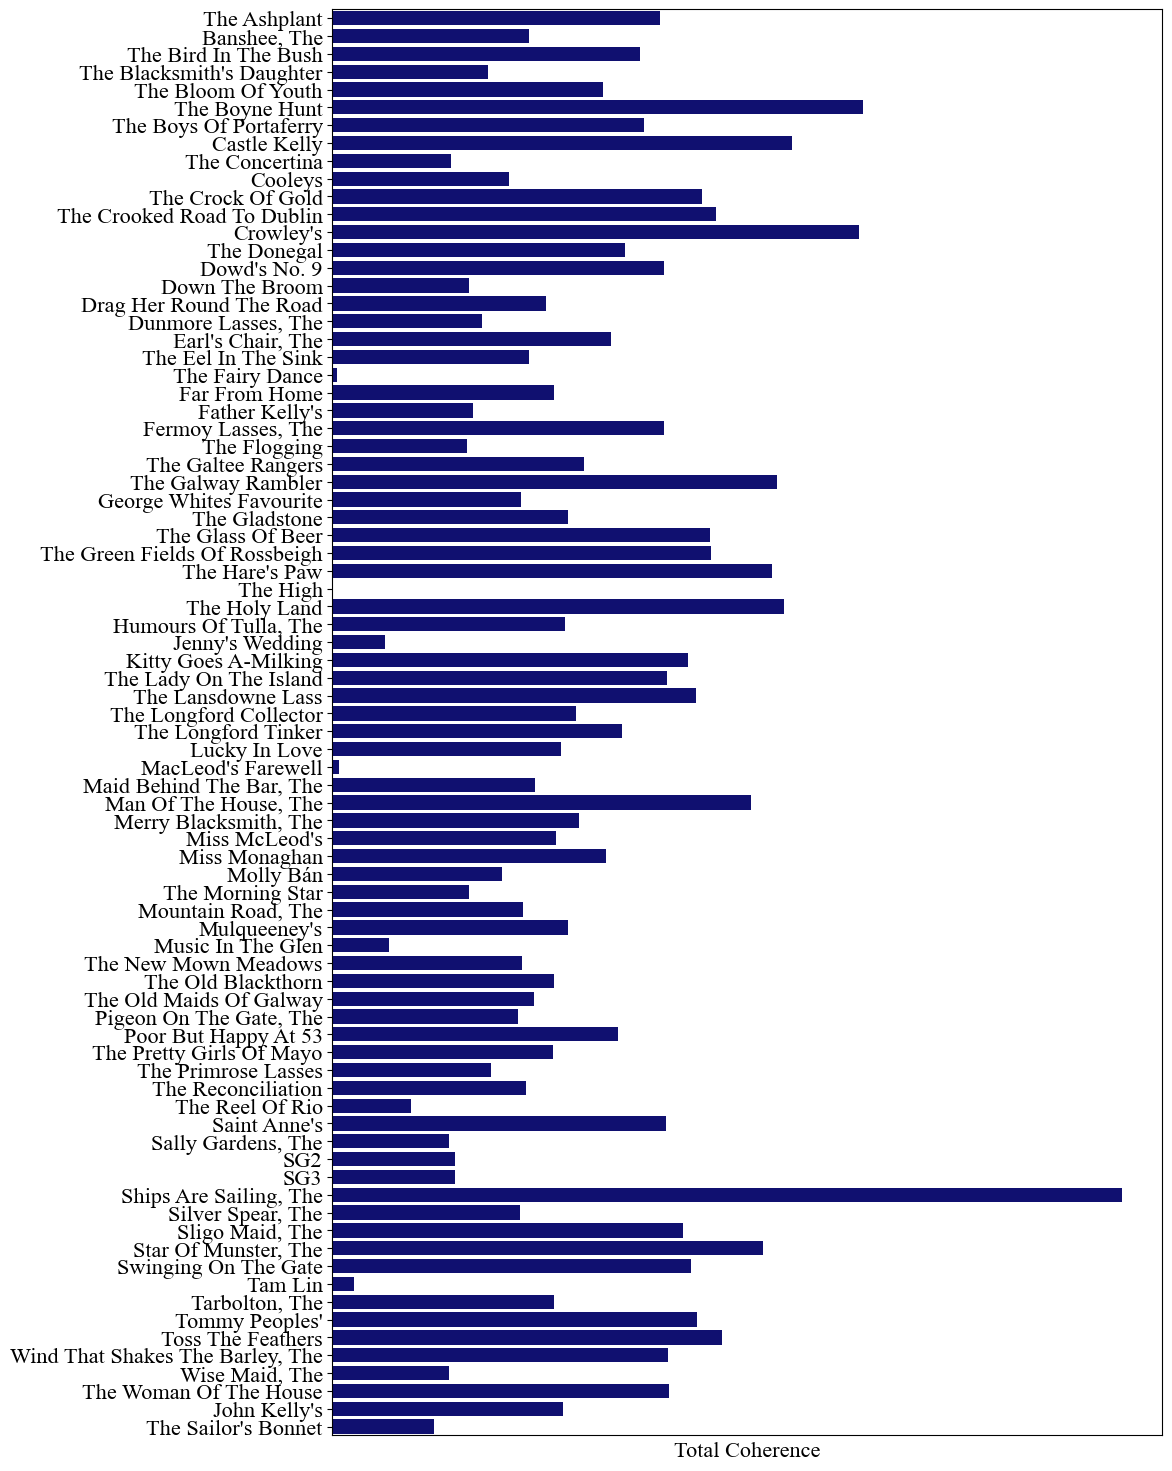

In [59]:
sumsflute,_ = record(plot = True,audio_data=signalflute)

In [62]:
plt.rcParams.update({'font.size': 12})  # sets default font size for all text


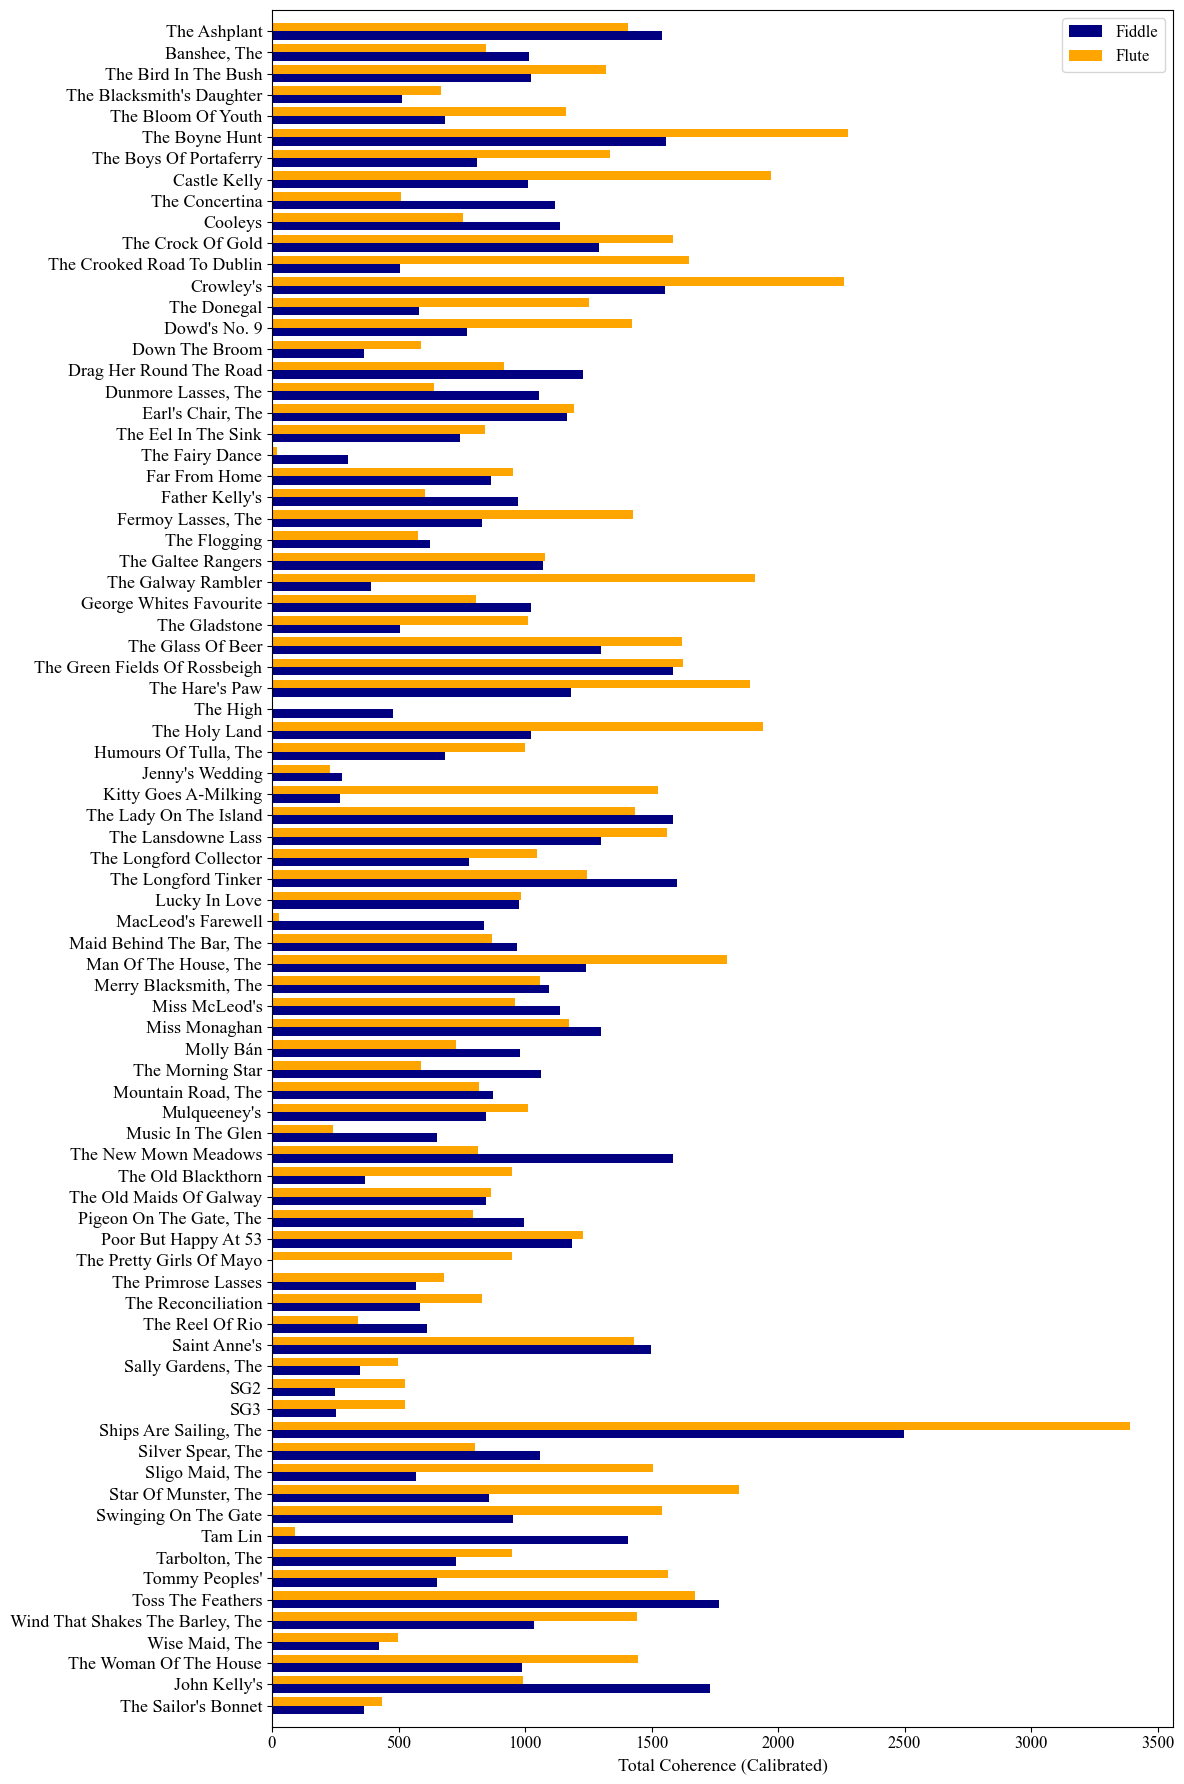

In [81]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Ensure both dicts have the same keys and order
keys = list(sumsfiddle.keys())
fiddle_vals = np.array([sumsfiddle[k] for k in keys])
flute_vals = np.array([sumsflute[k] for k in keys])

# Normalize both to start from 0 for fair comparison
fiddle_vals = fiddle_vals - fiddle_vals.min()
flute_vals = flute_vals - flute_vals.min()

# Create DataFrame for plotting
df = pd.DataFrame({
    'Tune': keys,
    'Fiddle': fiddle_vals,
    'Flute': flute_vals
})[::-1].reset_index(drop=True)

# Sort by Fiddle or Flute if desired, e.g., by Fiddle
#df = df.sort_values('Fiddle', ascending=False)

# Plot
plt.figure(figsize=(12, 18))
bar_width = 0.4
y = np.arange(len(df))

plt.barh(y - bar_width/2, df['Fiddle'], height=bar_width, color='navy', label='Fiddle')
plt.barh(y + bar_width/2, df['Flute'], height=bar_width, color='orange', label='Flute')

plt.ylim(y[0] - 1, y[-1] + 1)

plt.yticks(y, df['Tune'], fontsize=13)
plt.xlabel('Total Coherence (Calibrated)',fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

In [87]:
def transformp(signal1,frame_rate,clip_point,correction= True):
    highest = 4000
    lowest = 200
    nfreqs = 200
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')
    coeffs1 = reduce_resolution(coeffs1, (800, 300))
    if correction:
        coeffs1 = gamma_correction_complex(coeffs1,clip_point = clip_point)
    return coeffs1,freqs

def transform_plotter(signal,frame_rate,clip_point,correction = True):


    coeffs1,freqs = transformp(signal,frame_rate,clip_point,correction)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, len(signal)/frame_rate, len(freqs),0]

    hmap = np.abs(coeffs1)
    hmap = hmap / np.max(hmap)  # Normalize hmap



    plt.figure(figsize=(10, 5))
    plt.imshow(hmap, aspect='auto', extent=extent, cmap='jet')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Magnitude')
    cbar.set_ticks([])  
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    #plt.title('Wavelet Transform Magnitude')
    plt.tight_layout()
    plt.show()
    return coeffs1,freqs

#ransform_plotter(banshee[:8000],frame_rate,clip_point = .1,correction = False)

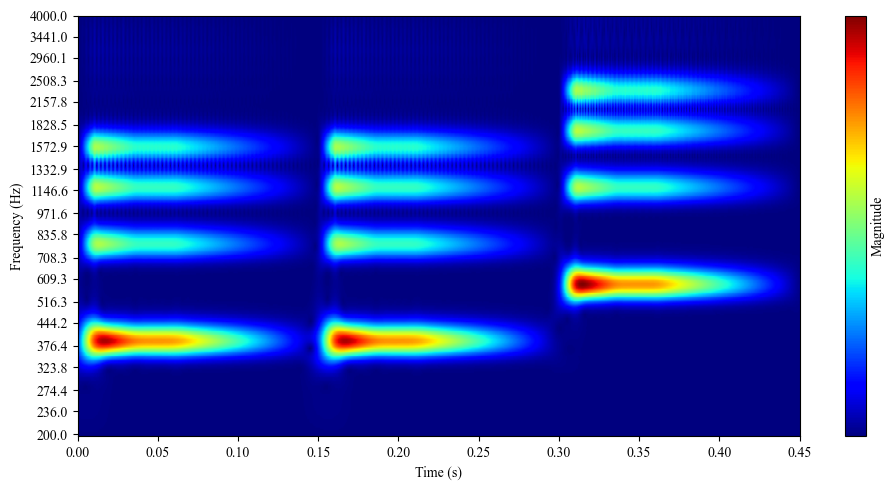

(array([[ 3.26007401e-04+1.2567147e-04j,  2.64778355e-04+1.5946751e-04j,
          3.89677443e-04-3.7924715e-04j, ...,
          9.97702446e-05+1.5666707e-04j,  1.28239277e-04-5.4699762e-05j,
          1.02976584e-04-1.1573523e-04j],
        [ 3.33406409e-04+1.2596790e-04j,  2.51667778e-04+1.5892096e-04j,
          4.14809649e-04-3.4573855e-04j, ...,
          1.07884458e-04+1.5263997e-04j,  1.27944368e-04-5.1954969e-05j,
          1.03563638e-04-1.2223731e-04j],
        [ 3.41825449e-04+1.2343113e-04j,  2.37273707e-04+1.6003389e-04j,
          4.46671358e-04-2.9671591e-04j, ...,
          1.19076096e-04+1.4560574e-04j,  1.28126150e-04-4.7832986e-05j,
          1.03015016e-04-1.2953735e-04j],
        ...,
        [-1.15251564e-03+6.3343713e-04j, -1.28759898e-03-3.5376719e-04j,
         -6.88483706e-04-1.1712130e-03j, ...,
         -4.32741836e-05-4.1828262e-05j, -6.09360904e-06-5.7047233e-05j,
          3.05355497e-05-4.5734752e-05j],
        [-1.07354997e-03+5.3115562e-04j, -1.1571631

In [112]:
transform_plotter(tunes[26].waveform[:3600],frame_rate,.05,correction = False)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# --- Parameters ---
fs = 8000
duration = 1.0
n_samples = int(fs * duration)
frequencies = [0.003, 0.005, 0.0075, 0.01]
frequencies.reverse()  # cycles/sample
n_segments = 20
segment_len = n_samples // n_segments
t = np.arange(n_samples)

# --- Generate synthetic signal with random frequency segments ---
rng = np.random.default_rng(42)
signal = np.zeros(n_samples)
masks = {f: np.zeros(n_samples, dtype=bool) for f in frequencies}

for i in range(n_segments):
    start = i * segment_len
    end = start + segment_len
    t_seg = np.arange(segment_len)
    
    # Weighted selection to make 0.003 less likely
    weights = [0.2 if f == 0.003 else 1.0 for f in frequencies]
    prob = np.array(weights) / np.sum(weights)

    n_freqs = rng.integers(0, len(frequencies)+1)
    freqs_here = rng.choice(frequencies, size=n_freqs, replace=False, p=prob)

    segment = np.zeros(segment_len)
    for f in freqs_here:
        segment += np.sin(2 * np.pi * f * t_seg)
        masks[f][start:end] = True
    segment *= np.hanning(segment_len)
    signal[start:end] += segment


signal /= np.max(np.abs(signal))
signal += 0.00 * rng.normal(size=n_samples)



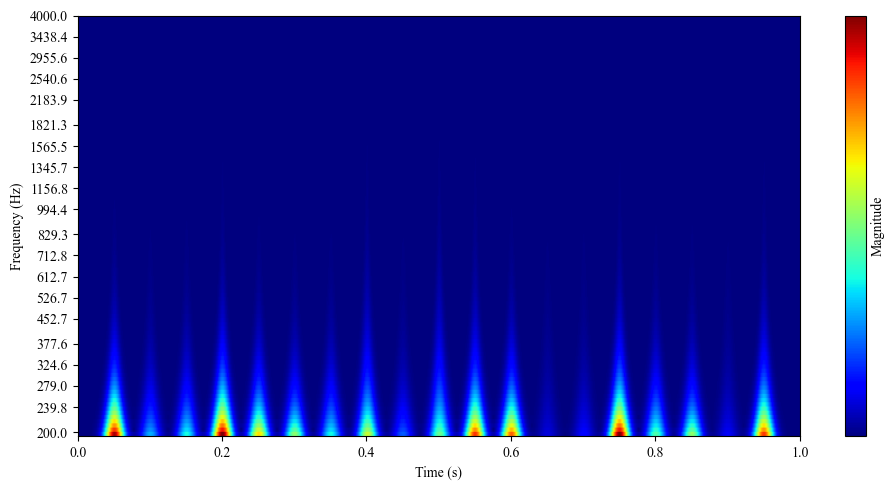

(array([[ 5.7827751e-09+1.06287690e-08j,  9.0492449e-09+2.83159407e-09j,
          1.8167678e-10+3.34287420e-09j, ...,
          2.3552691e-09+1.99574117e-08j,  1.8639724e-08+1.10658815e-08j,
          1.3098530e-08+4.55017535e-09j],
        [ 5.7827751e-09+1.06287690e-08j,  9.0492449e-09+2.83159407e-09j,
          1.8167678e-10+3.34287420e-09j, ...,
          2.3552691e-09+1.99574117e-08j,  1.8639724e-08+1.10658815e-08j,
          1.3098530e-08+4.55017535e-09j],
        [ 5.8547456e-09+1.05892957e-08j,  9.3000887e-09+1.84799986e-09j,
          2.9671514e-09+1.55042812e-09j, ...,
          2.1086535e-09+1.99849719e-08j,  1.9009894e-08+1.04171480e-08j,
          1.3081448e-08+4.59905625e-09j],
        ...,
        [ 8.5654778e-10-1.82337467e-09j, -1.3474204e-09-2.35553910e-09j,
          3.6831023e-09-3.62486019e-09j, ...,
          1.5255550e-10-5.09647657e-09j,  2.7720553e-09-1.05966602e-09j,
          8.5427948e-10-2.30686892e-09j],
        [-1.7957685e-09-9.13008447e-10j, -3.7632716

In [72]:
transform_plotter(signal,frame_rate,clip_point = .1,correction = False)

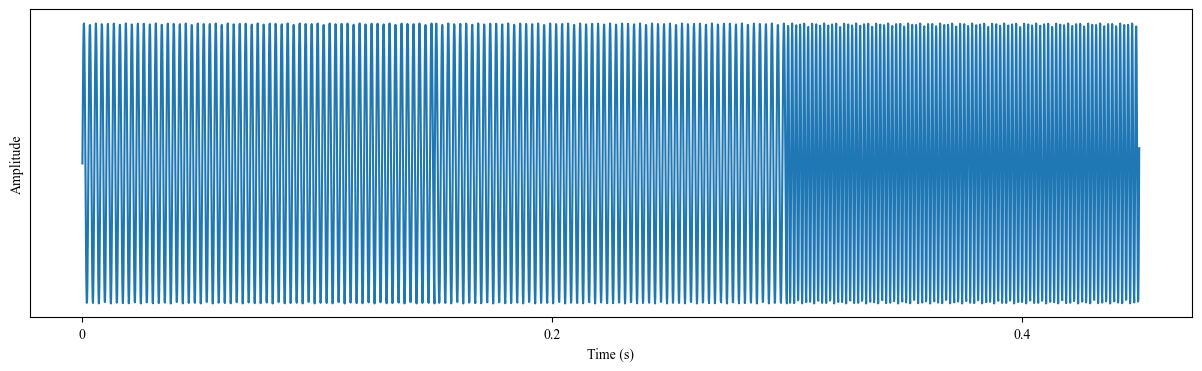

In [75]:
x = tunes[26].waveform
plt.figure(figsize=(15, 4))  # Set a large figure size
plt.xlabel('Time (s)')
plt.xticks([0,int(8000/5),2*int(8000/5),int(8000/5)*3,int(8000/5)*4,8000],[0,.2,.4,.6,.8,1])
plt.yticks([])  # Turn off y-axis ticks
plt.ylabel('Amplitude')
plt.plot(x[:3600])

In [77]:
def dict_to_latex_table(data, caption="Dictionary", label="tab:dict"):
    """
    Converts a dictionary to a LaTeX tabular string.

    Parameters:
        data (dict): The dictionary to format.
        caption (str): Table caption.
        label (str): Table label for referencing.

    Returns:
        str: A string of LaTeX code.
    """
    lines = [
        "\\begin{table}[h!]",
        "\\centering",
        "\\begin{tabular}{|l|l|}",
        "\\hline",
        "\\textbf{Key} & \\textbf{Value} \\\\",
        "\\hline"
    ]

    for key, value in data.items():
        lines.append(f"{key} & {value} \\\\")
        lines.append("\\hline")

    lines.extend([
        "\\end{tabular}",
        f"\\caption{{{caption}}}",
        f"\\label{{{label}}}",
        "\\end{table}"
    ])

    return "\n".join(lines)



latex_code = dict_to_latex_table(universal_encoder, caption="Hyperparameters", label="tab:hyperparams")
print(latex_code)


\begin{table}[h!]
\centering
\begin{tabular}{|l|l|}
\hline
\textbf{Key} & \textbf{Value} \\
\hline
G, & -5 \\
\hline
^G, & -4 \\
\hline
A, & -3 \\
\hline
^A, & -2 \\
\hline
B, & -1 \\
\hline
C & 0 \\
\hline
^C & 1 \\
\hline
D & 2 \\
\hline
^D & 3 \\
\hline
E & 4 \\
\hline
F & 5 \\
\hline
^F & 6 \\
\hline
G & 7 \\
\hline
^G & 8 \\
\hline
A & 9 \\
\hline
^A & 10 \\
\hline
B & 11 \\
\hline
c & 12 \\
\hline
^c & 13 \\
\hline
d & 14 \\
\hline
^d & 15 \\
\hline
e & 16 \\
\hline
f & 17 \\
\hline
^f & 18 \\
\hline
g & 19 \\
\hline
^g & 20 \\
\hline
a & 21 \\
\hline
^a & 22 \\
\hline
b & 23 \\
\hline
c. & 24 \\
\hline
^c. & 25 \\
\hline
d. & 26 \\
\hline
^d. & 27 \\
\hline
e. & 28 \\
\hline
f. & 29 \\
\hline
^f. & 30 \\
\hline
g. & 31 \\
\hline
^g. & 32 \\
\hline
a. & 33 \\
\hline
b. & 34 \\
\hline
\end{tabular}
\caption{Hyperparameters}
\label{tab:hyperparams}
\end{table}


In [168]:
import pickle

# Load the `tunes.pkl` file
with open('tunes.pkl', 'rb') as file:
    tunes = pickle.load(file)

print("tunesh loaded successfully")

tunesh loaded successfully


In [48]:
signalfiddle = _


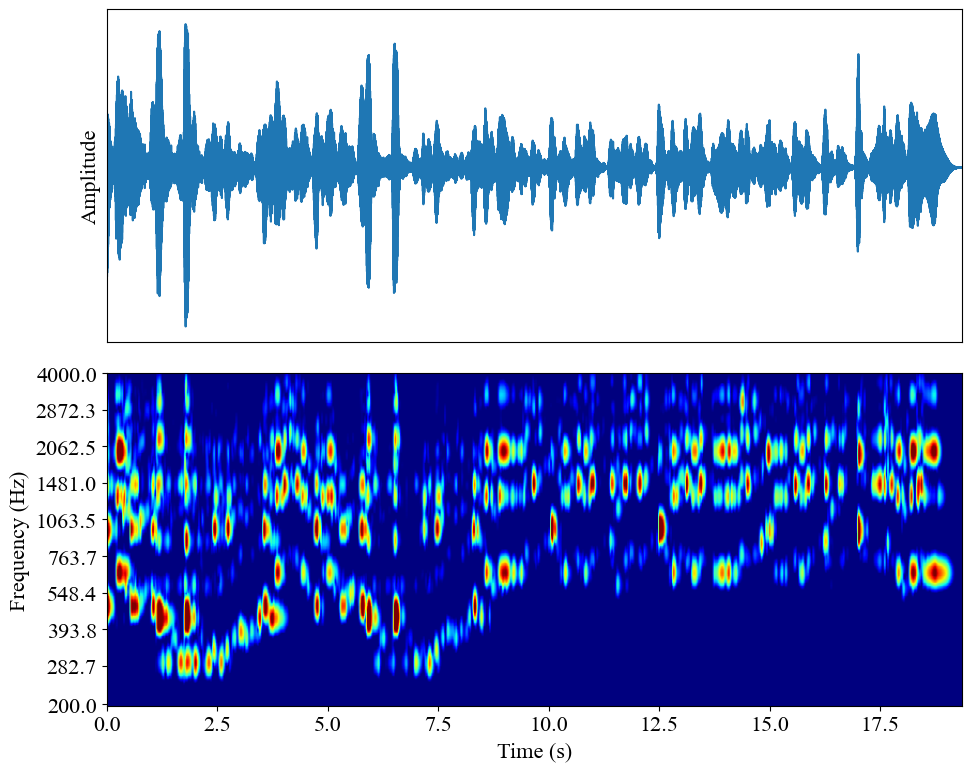

In [55]:
signal = signalfiddle
# Plot audio_data and its transform plot side by side
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 16})  # sets default font size for all text
# Plot audio_data
plt.subplot(2, 1, 1,)
plt.plot(signal)
plt.xlim([0,len(signal)])
plt.ylabel('Amplitude')
#plt.title('Audio Data')
plt.xticks([])
m = max(abs(signal))
plt.yticks([])
#plt.yticks([-m,0,m],labels=[-1,0,1])  # Assuming frame_rate = 8000

# Plot transform of audio_data
plt.subplot(2, 1, 2)



coeffs1,freqs = transform(signal,frame_rate,.05,correction = True)

y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
subsampled_indices = np.linspace(0, len(y_values) - 1, 10, dtype=int)
subsampled_y_values = y_values[subsampled_indices]
extent=[0, len(signal)/frame_rate, len(freqs),0]

hmap = np.abs(coeffs1)
hmap = hmap / np.max(hmap)  # Normalize hmap


plt.imshow(hmap, aspect='auto', extent=extent, cmap='jet')
plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

#cbar = plt.colorbar()
#cbar.ax.set_ylabel('Magnitude')
#cbar.set_ticks([])  
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
#plt.title('Wavelet Transform Magnitude')
plt.tight_layout()
plt.show()

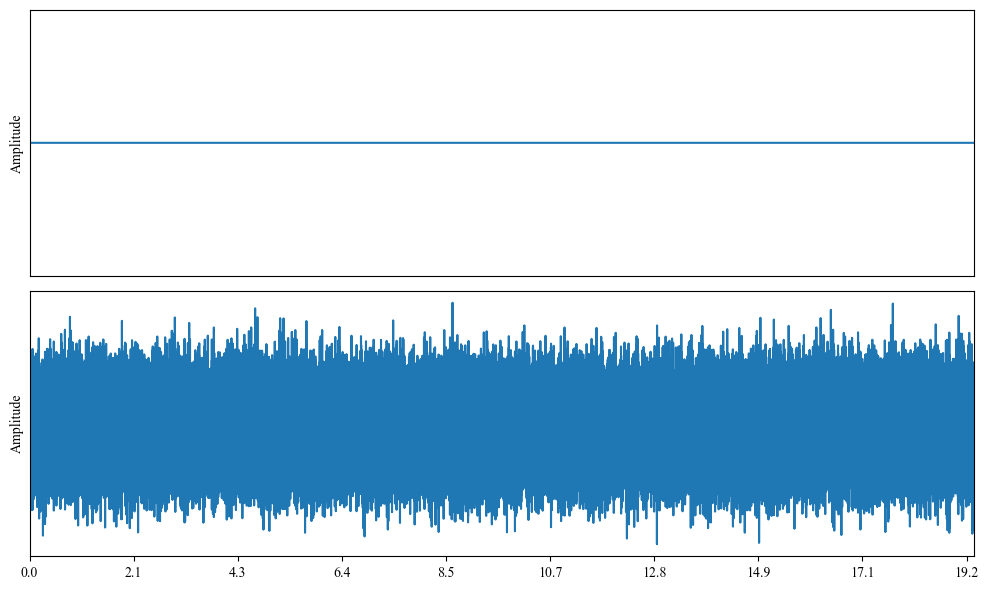

In [339]:
signal = audio_data
# Plot audio_data and its transform plot side by side
plt.figure(figsize=(10, 6))

# Plot audio_data
plt.subplot(2, 1, 1,)
plt.plot(np.zeros_like(signal))
plt.xlim([0,len(signal)])
plt.ylabel('Amplitude')
#plt.title('Audio Data')
plt.xticks([])
m = max(abs(signal))
plt.yticks([])


plt.subplot(2, 1, 2)

plt.plot(filtered_noise)
plt.xlim([0,len(signal)])
plt.ylabel('Amplitude')
#plt.title('Audio Data')
plt.xticks(np.linspace(0,153600,10),labels=np.round(np.linspace(0, 19.2, 10),1))  # Set x-axis ticks to 10 equally spaced points between 0 and 19.2
m = max(abs(signal))
plt.yticks([])
#plt.xticks(np.linspace(0, len(signal), 8), labels=np.round(np.linspace(0, 19.35, 8), 1))

plt.tight_layout()
plt.show()

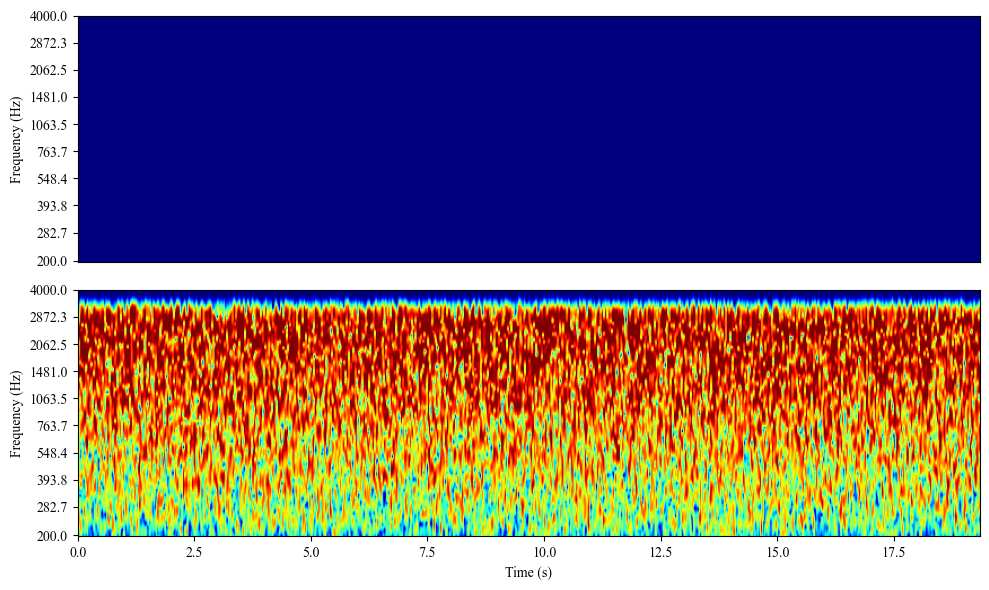

In [341]:
signal1 = np.zeros_like(audio_data)
signal2 = filtered_noise
def plot_stack(signal1, signal2):
    frame_rate = 8000
    # Plot audio_data and its transform plot side by side
    plt.figure(figsize=(10, 6))

    # Plot audio_data
    plt.subplot(2, 1, 1,)

    coeffs1,freqs = transform(signal1,frame_rate,.05,correction = True)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 10, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, len(signal)/frame_rate, len(freqs),0]

    hmap = np.abs(coeffs1)
    hmap = hmap / np.max(hmap)  # Normalize hmap


    plt.imshow(hmap, aspect='auto', extent=extent, cmap='jet')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    #cbar = plt.colorbar()
    #cbar.ax.set_ylabel('Magnitude')
    #cbar.set_ticks([])  
    #plt.xlabel('Time (s)')
    plt.xticks([])
    plt.ylabel('Frequency (Hz)')
    #plt.title('Wavelet Transform Magnitude')
    plt.tight_layout()
    plt.subplot(2, 1, 2)



    coeffs2,_ = transform(signal2,frame_rate,.05,correction = True)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 10, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, len(signal)/frame_rate, len(freqs),0]

    hmap = np.abs(coeffs2)
    hmap = hmap / np.max(hmap)  # Normalize hmap


    plt.imshow(hmap, aspect='auto', extent=extent, cmap='jet')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    #cbar = plt.colorbar()
    #cbar.ax.set_ylabel('Magnitude')
    #cbar.set_ticks([])  
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    #plt.title('Wavelet Transform Magnitude')
    plt.tight_layout()
    plt.show()

plot_stack(signal1, signal2)

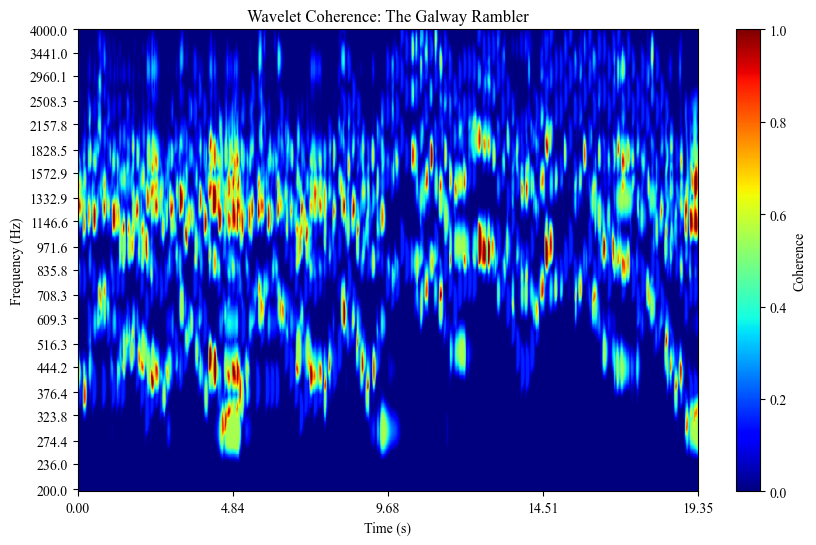

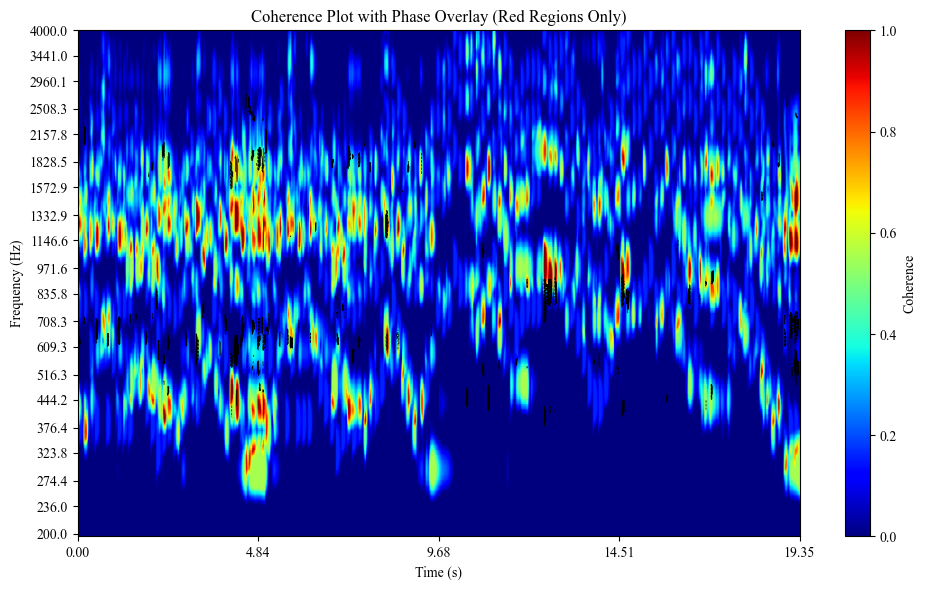

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

_,_,_,_,ob = coherence_plot(tunes[26],transform(audio_data,8000,.05)[0],frame_rate,plot=True)
cw = cross_wavelet(tunes[26].transform[0],transform(audio_data,8000,.05)[0],frame_rate,tunes[26].transform[1])

# Extract phases from the cross-wavelet transform
phases = np.angle(cw)

# Define a threshold for the magnitude (e.g., regions with high coherence)
magnitude = np.abs(cw)
threshold = 0.8  # Adjust this value based on your data
mask = magnitude >= threshold

# Apply the mask to the phases
masked_phases = np.where(mask, phases, np.nan)  # Set phases to NaN where the mask is False

# Overlay the masked phases on the existing plot object `ob`
plt.figure(figsize=(10, 6))

# Display the existing plot object `ob`
ob_axes = ob.gca()  # Get the axes from the plot object
plt.sca(ob_axes)    # Set the current axes to `ob_axes`

# Overlay the masked phases
extent = [0, len(audio_data)/8000, len(tunes[26].transform[1]), 0]  # Define the extent
plt.contour(masked_phases, levels=10, colors='black', linewidths=0.5, extent=extent)

plt.title('Coherence Plot with Phase Overlay (Red Regions Only)')
plt.tight_layout()
plt.show()

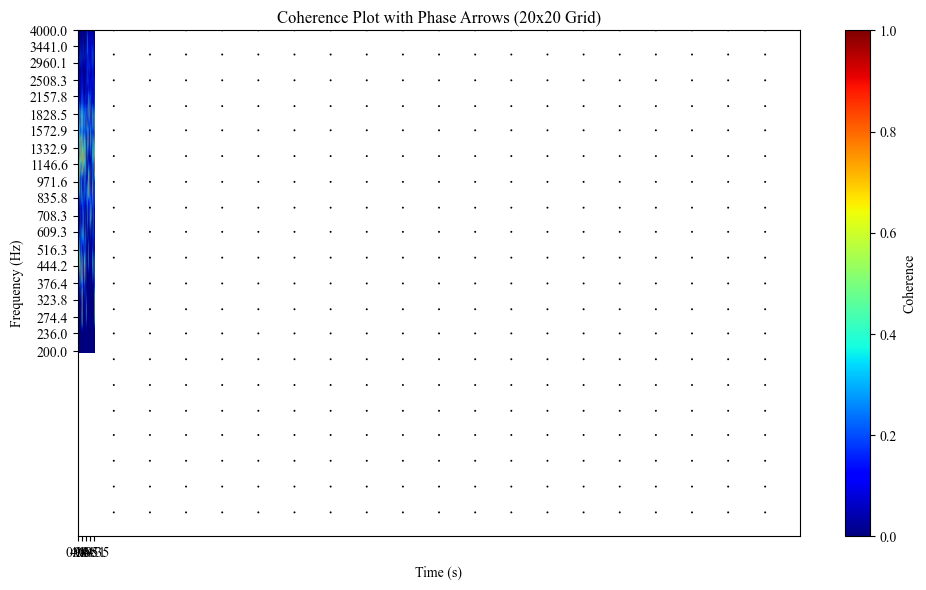

In [378]:
import numpy as np
import matplotlib.pyplot as plt
_,_,_,_,ob = coherence_plot(tunes[26],transform(audio_data,8000,.05)[0],frame_rate,plot=True)
cw = cross_wavelet(tunes[26].transform[0],transform(audio_data,8000,.05)[0],frame_rate,tunes[26].transform[1])

# Extract phases and magnitude from the cross-wavelet transform
phases = np.angle(cw)
magnitude = np.abs(cw)

# Define a threshold for the magnitude (e.g., regions with high coherence)
threshold = 0.8  # Adjust this value based on your data
mask = magnitude >= threshold

# Downsample the data to a 20x20 grid
grid_x = np.linspace(0, phases.shape[1] - 1, 20, dtype=int)
grid_y = np.linspace(0, phases.shape[0] - 1, 20, dtype=int)
phases_downsampled = phases[np.ix_(grid_y, grid_x)]
mask_downsampled = mask[np.ix_(grid_y, grid_x)]

# Compute arrow directions (u, v) based on the phase
u = np.cos(phases_downsampled) * mask_downsampled
v = np.sin(phases_downsampled) * mask_downsampled

# Overlay the arrows on the existing plot object `ob`
plt.figure(figsize=(10, 6))

# Display the existing plot object `ob`
ob_axes = ob.gca()  # Get the axes from the plot object
plt.sca(ob_axes)    # Set the current axes to `ob_axes`

# Overlay the arrows
extent = [0, len(audio_data)/8000, len(tunes[26].transform[1]), 0]  # Define the extent
x, y = np.meshgrid(grid_x, grid_y)
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='black')

plt.title('Coherence Plot with Phase Arrows (20x20 Grid)')
plt.tight_layout()
plt.show()

In [204]:
import pickle

# Load the `tuneslowres.pkl` file
with open('tuneslowrange.pkl', 'rb') as file:
    tunes = pickle.load(file)

print("tunes object loaded successfully")

tunes object loaded successfully


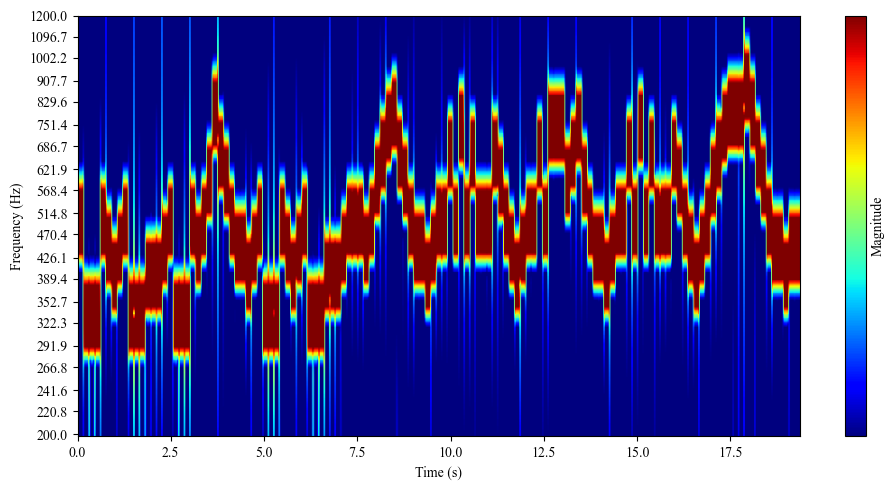

(array([[ 0.06729537+0.41955253j,  0.00758548+0.35037875j,
         -0.1331099 -0.32419837j, ...,  0.01390893+0.35018474j,
         -0.04177743+0.34796187j, -0.2658267 -0.22838339j],
        [-0.01015926+0.42530766j,  0.07057218+0.34328178j,
         -0.18031141-0.30051723j, ..., -0.07642837+0.3420256j ,
         -0.15546983+0.31408906j, -0.22947285-0.26488683j],
        [-0.11850522+0.40912357j,  0.25394708+0.2415237j ,
         -0.18090108-0.30016264j, ..., -0.18015951+0.3006083j ,
         -0.06920189+0.34356064j, -0.16622783-0.30853057j],
        ...,
        [-0.38461563+0.15794542j, -0.18541367+0.29739633j,
          0.11112304+0.33237702j, ...,  0.22298998-0.27036694j,
          0.24480942+0.25078112j,  0.34362012+0.06890593j],
        [-0.36798015+0.19241792j, -0.09709148+0.3367433j ,
          0.23381443+0.26106247j, ...,  0.16360886-0.30992734j,
          0.1664811 +0.308394j  ,  0.33568317+0.10069565j],
        [-0.35339648+0.21702965j, -0.02593337+0.34950003j,
          0.2

In [205]:
transform_plot(tunes[0].waveform,8000,clip_point = .05)

In [321]:
def transform(signal1,frame_rate,clip_point,correction= True):
    highest = 1200
    lowest = 200
    nfreqs = 200
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')
    coeffs1 = reduce_resolution(coeffs1, (800, 300))
    if correction:
        coeffs1 = gamma_correction_complex(coeffs1,clip_point = clip_point)
    return coeffs1,freqs

def plot_sums(sums):
    # Extract keys and values from the sums dictionary
    keys = list(sums.keys())
    values = np.array(list(sums.values()))  # Convert values to a NumPy array
    values = values - min(values)  # Normalize to start from 0
    
    # Create a DataFrame for easier plotting with Seaborn
    data = pd.DataFrame({'Tune': keys, 'Total Coherence': values})
    
    # Create a horizontal bar plot with Seaborn
    plt.figure(figsize=(4, 15))
    sns.barplot(x='Total Coherence', y='Tune', data=data,color = 'navy', orient='h')
    plt.xticks([])
    plt.yticks([],fontsize=10)
    plt.xlabel('')
    plt.ylabel('')
    
    plt.xlim(0,values.max()*1.2)  # Set x-axis limit to max value + 5 for better visibility
    #plt.title('Gross Coherence for Each Tune')
    plt.tight_layout()
    plt.show()

# workflow
import os
import shutil
def workflow(recording,frame_rate = 8000,plot = False,save = False,title = 'unspecified title',clip_point = .1):
    topk = 3 # number of top guesses to return
    file = f'recordings/{recording}'
    if file[-3:] == ('m4a'):
        tune = m4a_to_reel(file)
    elif file[-3:] == ('wav'):
        tune = wav_to_reel(file)
    elif type(recording) == np.ndarray or type(file) == list:
        tune = recording
        recording = title
    else:
        return "Unsupported input format"
    sums = {}
    tform = transform(tune,frame_rate,clip_point = clip_point,correction = True)
    
    output_dir = f'coherence_results/{recording}'
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # Remove only if it exists
    os.makedirs(output_dir)
    # Calculate the required number of rows
    plts = {}
    for n,i in enumerate(tunes):
        _,_,_,coh,plt_obj = coherence_plot(i,tform[0],frame_rate,plot=True)
        plts[i.T] = plt_obj
   
        sums[i.T] = np.where(coh<.5,0,coh).sum()
    min_value = min(sums.values())
    plot_sums(sums)
    top_keys = sorted(sums, key=sums.get, reverse=True)[:topk]

    
    if plot:
        for i in plts:
            if i in top_keys:
                value = plts[i]
                value.savefig(f'coherence_results/{recording}/{i}.png')

    if plot:
        if os.path.exists(f'coherence_results/{recording}'):
            create_subplots_from_png(f'coherence_results/{recording}/')
    if not save:
        shutil.rmtree(f'coherence_results/{recording}')
    min_value = min(sums.values())
    top_keys = sorted(sums, key=sums.get, reverse=True)[:5]
    print(f'Top Guesses: {top_keys}')
    # Divide all values by the minimum
    normalized_sums = {key: value - min_value + 5 for key, value in sums.items()}   
    keys = list(normalized_sums.keys())
    values = list(normalized_sums.values())
    if plot:
        plot_sums(normalized_sums)
    
    


In [308]:
import numpy as np
from scipy.signal import butter, sosfilt
#import soundfile as sf  # optional, for saving audio

# Parameters
duration = 19.35         # seconds
sample_rate = 8000    # Hz
lowcut = 200.0         # Hz
highcut = 3000       # Hz

# Generate white noise
samples = int(duration * sample_rate)
noise = np.random.normal(0, 1, samples)

# Design bandpass filter
sos = butter(10, [lowcut, highcut], btype='bandpass', fs=sample_rate, output='sos')
filtered_noise = sosfilt(sos, noise)

# Normalize
filtered_noise /= np.max(np.abs(filtered_noise))

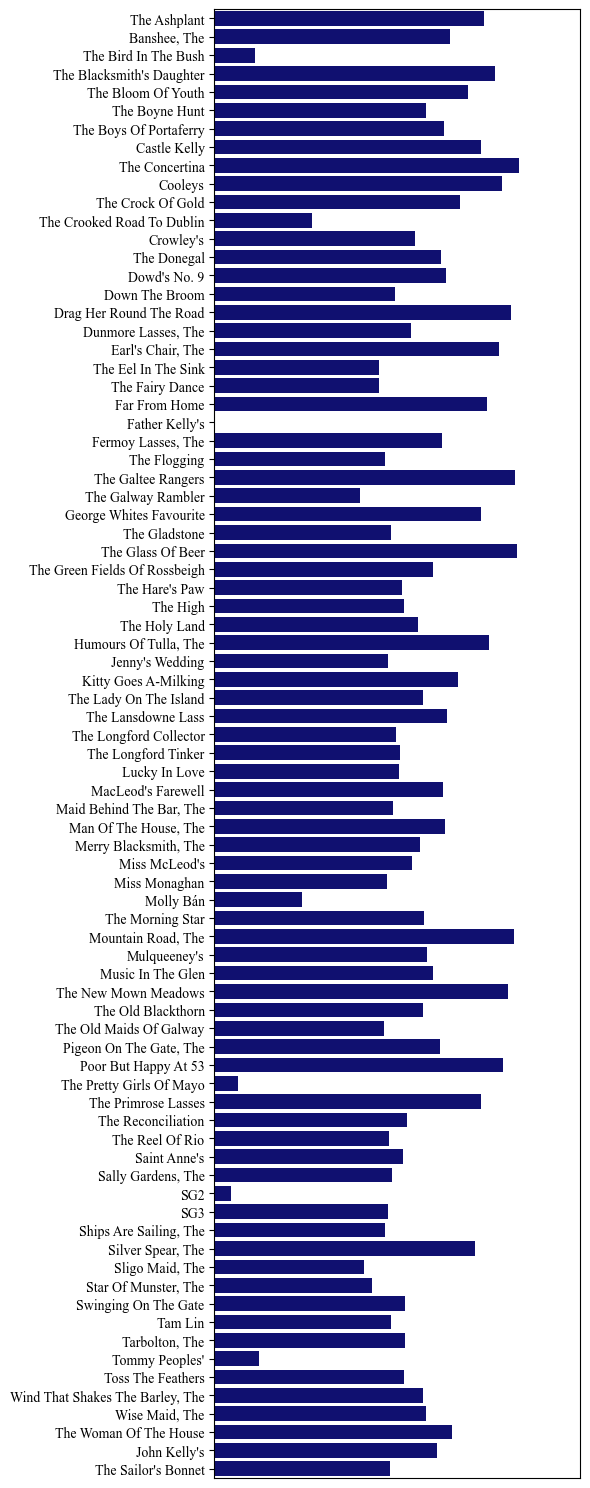

Top Guesses: ['The Concertina', 'The Glass Of Beer', 'The Galtee Rangers', 'Mountain Road, The', 'Drag Her Round The Road']


In [320]:
workflow(np.zeros(len(audio_data)),frame_rate,plot = False,save=False,title='test_recording',clip_point = .05)

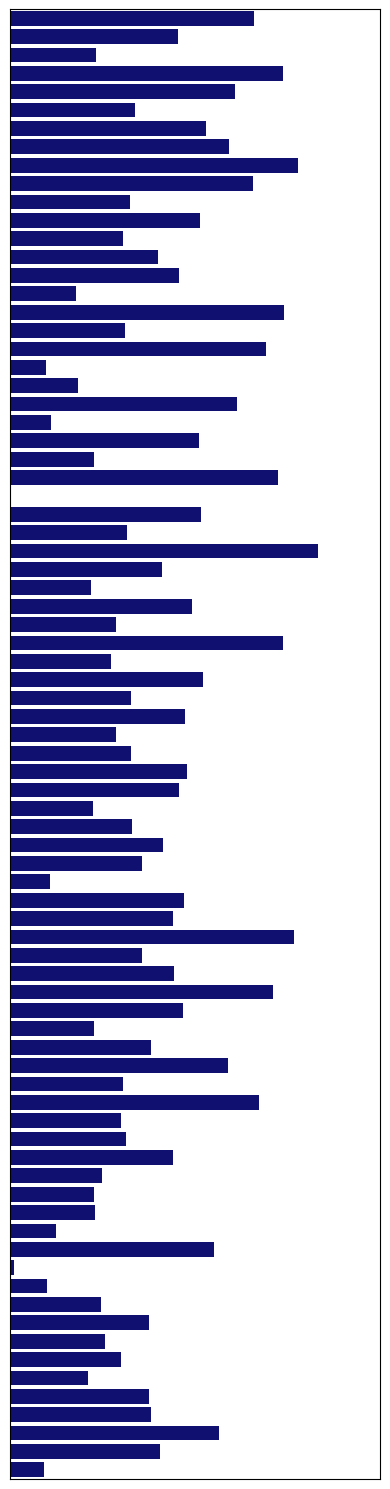

Top Guesses: ['The Glass Of Beer', 'The Concertina', 'Mountain Road, The', 'Drag Her Round The Road', "The Blacksmith's Daughter"]


In [322]:
workflow(filtered_noise,frame_rate,plot = False,save=False,title='test_recording',clip_point = .05)

In [326]:
from PIL import Image

def stitch_images(image1_path, image2_path, output_path):
    # Open the images
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)

    # Get dimensions of the images
    width1, height1 = image1.size
    width2, height2 = image2.size

    # Create a new image with combined width and max height
    stitched_image = Image.new('RGB', (width1 + width2, max(height1, height2)))

    # Paste the images side by side
    stitched_image.paste(image1, (0, 0))
    stitched_image.paste(image2, (width1, 0))

    # Save the stitched image
    stitched_image.save(output_path)

# Paths to the images
image1_path = 'c:/Users/E7450/Documents/MSResearch/Wavelet-Tech/Thesis/biasesblank.png'
image2_path = 'c:/Users/E7450/Documents/MSResearch/Wavelet-Tech/Thesis/biasesnoise.png'
output_path = 'c:/Users/E7450/Documents/MSResearch/Wavelet-Tech/Thesis/stitchedbiases.png'

# Stitch the images
stitch_images(image1_path, image2_path, output_path)

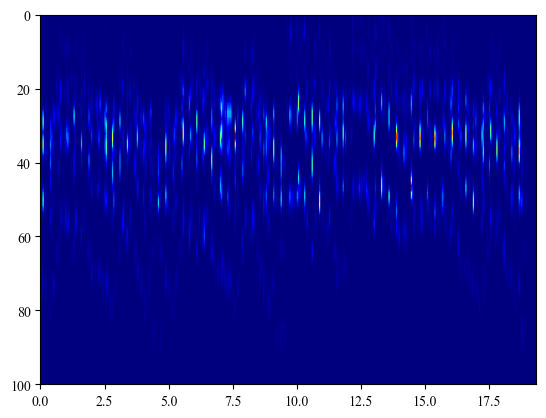

In [115]:
x  =transform(audio_data,frame_rate,.05,correction = False)[0]
y = transform(tunes[77].waveform,frame_rate,.05,correction = False)[0]
s = cross_wavelet(x,y,frame_rate,freqs)
plt.imshow(np.abs(s), aspect='auto', extent=extent, cmap='jet')